# **Air Quality Prediction**



In [1]:
import warnings
warnings.filterwarnings('ignore')
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Ingestion Stage

In [2]:
# API RUL
API_URL = "https://api.aqi.in/api/v1/getIndiaLocations"
response = requests.get(API_URL)
# checking request was successful or not
if response.status_code == 200:
    data1 = response.json()
    print(data1)
else:
    print("Error:", response.status_code) # printing error

{'Locations': [{'stationname': 'F Block,Sirsa,Haryana,India', 'locationId': '11850', 'dev_type': 1, 'lat': '29.5364', 'lon': '75.0158', 'Elevation': '200', 'updated_at': '2024-04-07 23:04:04', 'formatdate': '07 Apr 2024, 11:04pm', 'timeStamp': '1709870400', 'cityName': 'Sirsa', 'stateName': 'Haryana', 'countryName': 'India', 'source': 'World Air Quality Index Project', 'sourceUrl': 'https://waqi.info', 'airComponents': [{'sensorName': 'co', 'sensorData': 704, 'senDevId': 'co', 'sensorUnit': 'ppb'}, {'sensorName': 'no2', 'sensorData': 4, 'senDevId': 'no2', 'sensorUnit': 'ppb'}, {'sensorName': 'o3', 'sensorData': 48, 'senDevId': 'o3', 'sensorUnit': 'ppb'}, {'sensorName': 'pm10', 'sensorData': 98, 'senDevId': 'pm10', 'sensorUnit': 'ug/m3'}, {'sensorName': 'pm25', 'sensorData': 26, 'senDevId': 'pm25', 'sensorUnit': 'ug/m3'}, {'sensorName': 'so2', 'sensorData': 24, 'senDevId': 'so2', 'sensorUnit': 'ppb'}, {'sensorName': 'AQI-IN', 'sensorData': 98, 'senDevId': 'AQI-IN', 'sensorUnit': 'IN-AQI

# 2. Data Cleaning Stage

In [3]:
data = pd.json_normalize(data1, 'Locations')


In [4]:
sensor_val = pd.json_normalize(data['airComponents'])
sensor_val.shape
sensor = pd.DataFrame()
for col in sensor_val.columns:
    col_name = sensor_val[col][0]['sensorName'] + "_" + sensor_val[col][0]['sensorUnit']
    sensor[col_name] = sensor_val[col].apply(lambda x: x['sensorData'])




In [5]:
final_data = pd.merge(data, sensor, left_index = True, right_index = True)

# dropping those column that are not needed for the prediction purpose.
final_data.drop(columns = ['stationname', 'locationId','formatdate' ,'dev_type', 'updated_at', 'timeStamp', 'cityName', 'stateName',
       'countryName', 'source', 'sourceUrl', 'airComponents' ], inplace = True)

final_data.columns

Index(['lat', 'lon', 'Elevation', 'co_ppb', 'no2_ppb', 'o3_ppb', 'pm10_ug/m3',
       'pm25_ug/m3', 'so2_ppb', 'AQI-IN_IN-AQI', 'aqi_US-AQI', 't_C', 'p_mb',
       'dew_C', 'h_%', 'w_km/h', 'wd_'],
      dtype='object')

# 3. EDA

In [6]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   lat            379 non-null    object
 1   lon            379 non-null    object
 2   Elevation      355 non-null    object
 3   co_ppb         379 non-null    int64 
 4   no2_ppb        379 non-null    int64 
 5   o3_ppb         379 non-null    int64 
 6   pm10_ug/m3     379 non-null    int64 
 7   pm25_ug/m3     379 non-null    int64 
 8   so2_ppb        379 non-null    int64 
 9   AQI-IN_IN-AQI  379 non-null    int64 
 10  aqi_US-AQI     379 non-null    int64 
 11  t_C            379 non-null    int64 
 12  p_mb           379 non-null    int64 
 13  dew_C          379 non-null    int64 
 14  h_%            379 non-null    int64 
 15  w_km/h         379 non-null    int64 
 16  wd_            379 non-null    int64 
dtypes: int64(14), object(3)
memory usage: 50.5+ KB


**Observation:**
1.  Latitude, longitude and elivation columns are in object format. They need to be changed into numerical column.  

In [7]:
final_data['lon'] = pd.to_numeric(data['lon'])
final_data['lat'] = pd.to_numeric(data['lat'])
final_data['Elevation'] = pd.to_numeric(data['Elevation'])

In [8]:
#Checking for null values
final_data.isna().sum()

lat               0
lon               0
Elevation        24
co_ppb            0
no2_ppb           0
o3_ppb            0
pm10_ug/m3        0
pm25_ug/m3        0
so2_ppb           0
AQI-IN_IN-AQI     0
aqi_US-AQI        0
t_C               0
p_mb              0
dew_C             0
h_%               0
w_km/h            0
wd_               0
dtype: int64

In [9]:
# Filling null values by mean in column Elevation
final_data['Elevation'] = final_data['Elevation'].fillna(final_data['Elevation'].mean())

In [10]:
final_data.describe()

,lat,lon,Elevation,co_ppb,no2_ppb,o3_ppb,pm10_ug/m3,pm25_ug/m3,so2_ppb,AQI-IN_IN-AQI,aqi_US-AQI,t_C,p_mb,dew_C,h_%,w_km/h,wd_
count,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000
mean,22.624944,78.704557,275.873239,811.567282,20.237467,14.155673,117.065963,44.005277,5.511873,115.419525,114.910290,27.029024,973.683377,13.321900,46.042216,6.717678,218.728232
std,6.150064,4.702963,304.313840,701.432384,20.884833,11.728838,81.647315,30.622898,5.123526,82.439047,45.124606,3.583723,38.565755,7.120417,20.846080,4.084035,90.749423
min,8.514057,72.456691,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,9.000000,8.000000,-5.000000,671.000000,-14.000000,16.000000,0.000000,0.000000
25%,18.478676,76.119186,57.500000,383.000000,6.000000,6.000000,69.500000,25.000000,2.000000,71.500000,82.000000,25.000000,958.000000,7.000000,30.000000,4.000000,159.500000
50%,24.261301,77.400574,211.000000,674.000000,13.000000,11.000000,100.000000,39.000000,4.000000,101.000000,110.000000,28.000000,983.000000,13.000000,38.000000,6.000000,238.000000
75%,28.398842,80.256231,318.500000,1018.500000,29.000000,19.000000,142.000000,54.000000,7.000000,135.000000,147.000000,29.000000,1000.000000,19.000000,65.500000,9.000000,287.000000
max,34.161190,94.098988,2228.000000,7292.000000,137.000000,70.000000,954.000000,284.000000,36.000000,1055.000000,337.000000,35.000000,1009.000000,28.000000,100.000000,20.000000,360.000000


In [11]:
# def air_quality(aqi_value):
#     if aqi_value <= 50:
#         return "Good"
#     elif 51 <= aqi_value <= 100:
#         return "Moderate"
#     elif 101 <= aqi_value <= 200:
#         return "Poor"
#     elif 201 <= aqi_value <= 300:
#         return "Unhealthy"
#     elif 301 <= aqi_value <= 400:
#         return "Very Unhealthy"
#     else:
#         return "Hazardous"

# # Creating a 'Classify_AQI' column, use the air_quality function.
# final_data['Classify_AQI'] = final_data['AQI-IN_IN-AQI'].apply(lambda x: air_quality(x))

# final_data.head(5)

In [12]:
# Observation max value of AQI-IN is 1094 which might be an outliers. Analyzing the same data.
final_data[final_data['AQI-IN_IN-AQI'] > 500]

,lat,lon,Elevation,co_ppb,no2_ppb,o3_ppb,pm10_ug/m3,pm25_ug/m3,so2_ppb,AQI-IN_IN-AQI,aqi_US-AQI,t_C,p_mb,dew_C,h_%,w_km/h,wd_
245,14.4758,75.9052,592.0,681,10,22,954,34,4,1055,97,28,943,21,67,15,258


In [13]:
# It is observed that the data AQI IN is 1094 and AQI-US is 0 which does not make any sense in the data. Thus dropping the data.
final_data.drop(index = final_data[final_data['AQI-IN_IN-AQI'] > 1000].index, inplace = True)

**Univariate analysis**


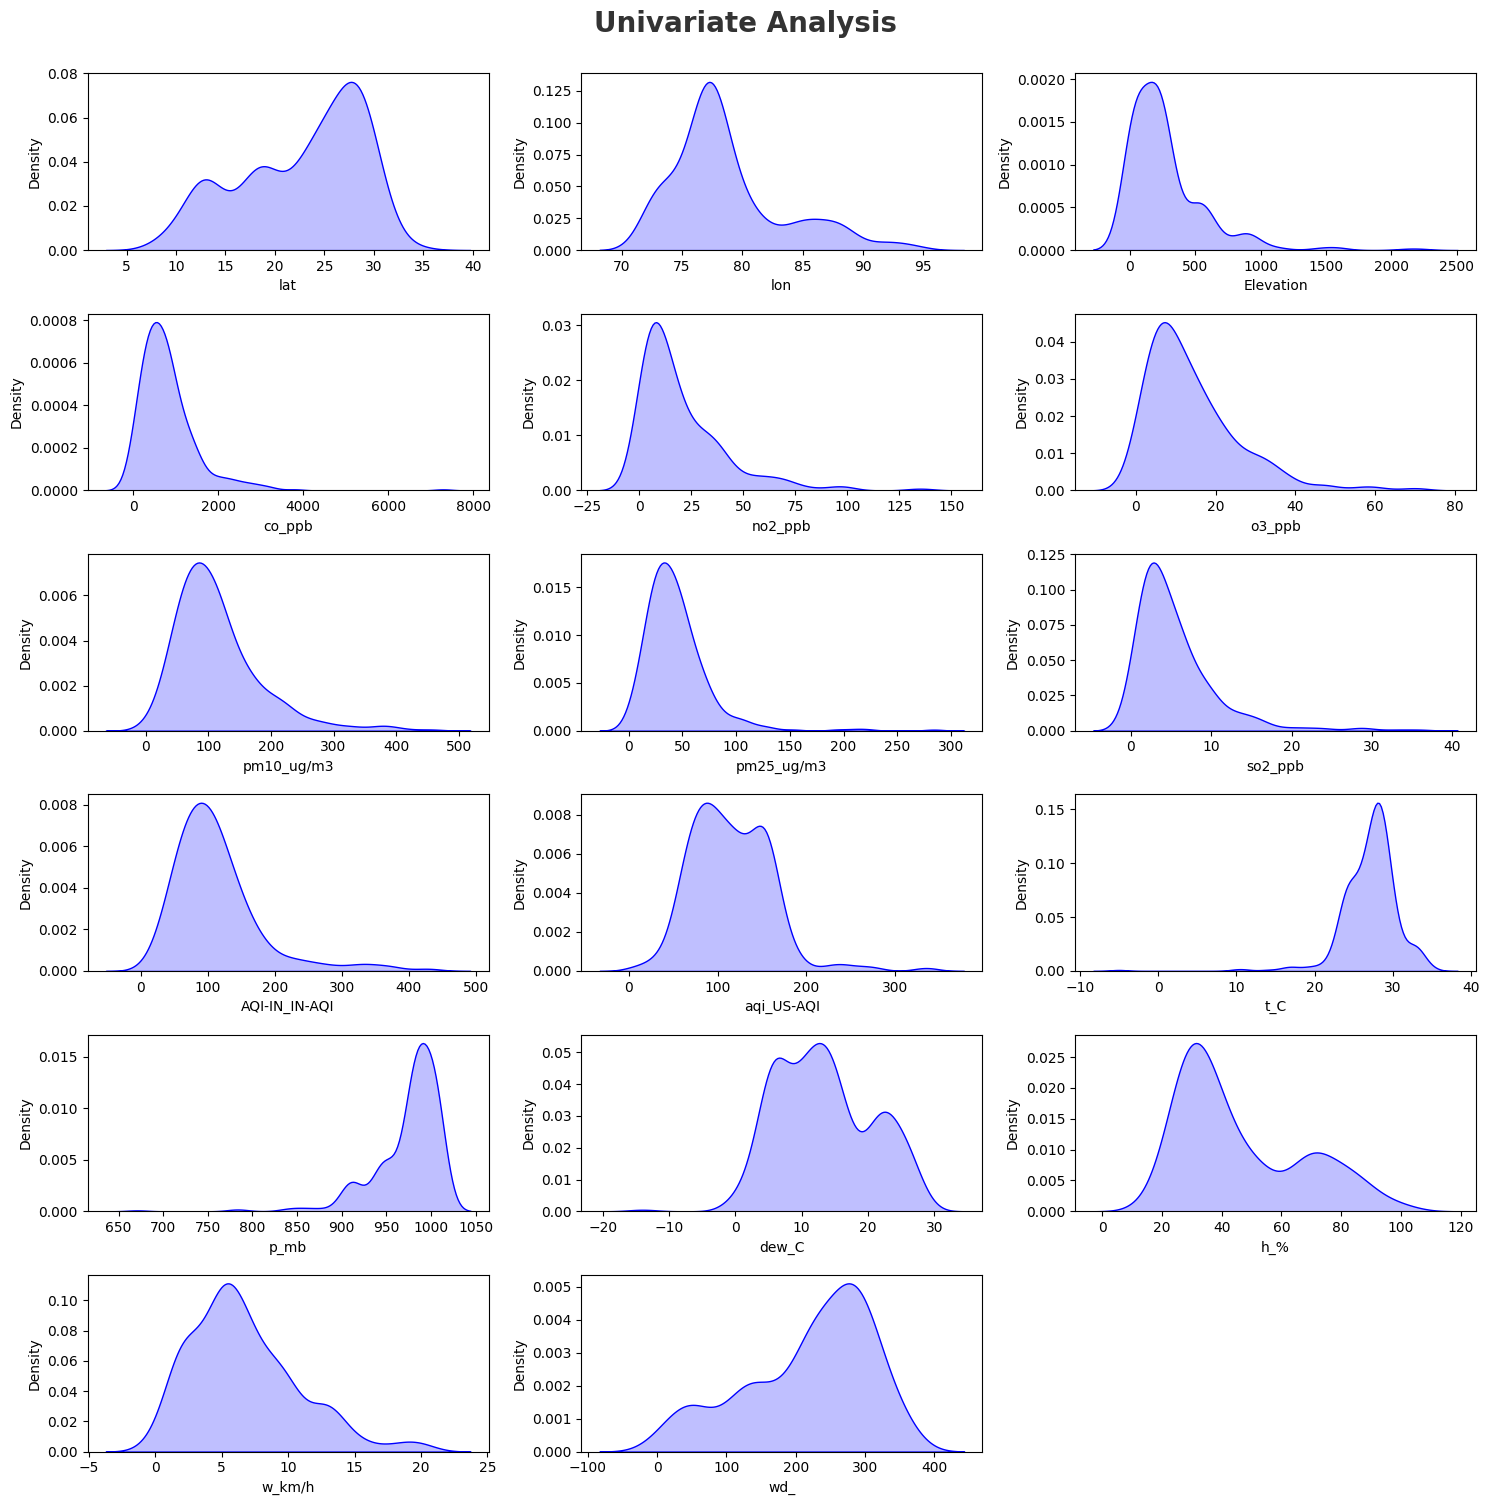

In [14]:
numerical_features = [col for col in final_data.columns if final_data[col].dtypes != 'O']
len(numerical_features)
plt.figure(figsize=(15, 15))
plt.suptitle('Univariate Analysis', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(numerical_features)):
    plt.subplot(6,3 , i+1)
    sns.kdeplot(x=final_data[numerical_features[i]],shade=True, color='b')
    plt.xlabel(numerical_features[i])
    plt.tight_layout()

**Multivariate Analysis**

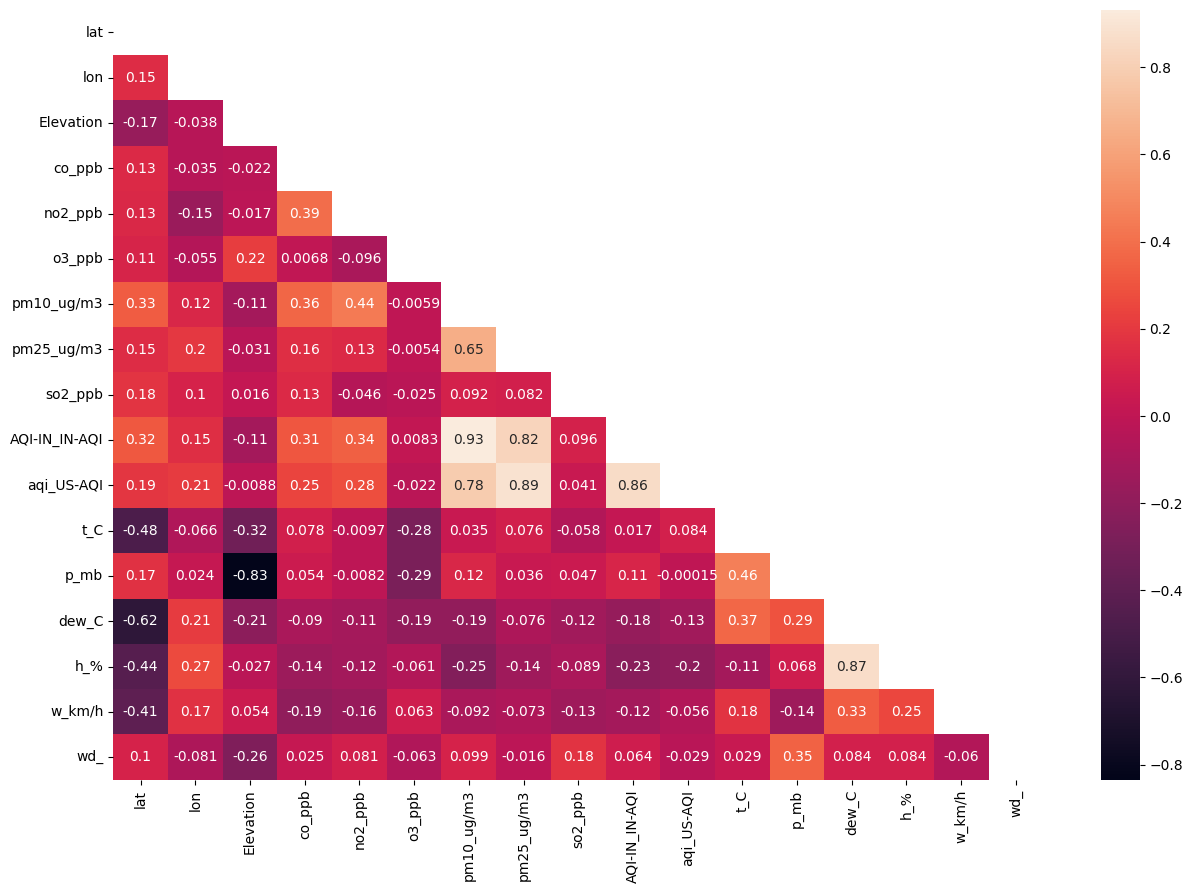

In [15]:
# Select only numeric columns
numeric_columns = final_data.select_dtypes(include=np.number)

# Plot heatmap
plt.figure(figsize=(15, 10))
matrix = np.triu(numeric_columns.corr())
sns.heatmap(numeric_columns.corr(), annot=True, mask=matrix)
plt.yticks(rotation=0)
plt.show()


# 4. Model Training

In [16]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
# from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [17]:
# final_data = final_data.sample(frac = 1)
# final_data

In [18]:
# final_data = final_data.reset_index()
# final_data = final_data.drop(columns=['index'])
final_data

,lat,lon,Elevation,co_ppb,no2_ppb,o3_ppb,pm10_ug/m3,pm25_ug/m3,so2_ppb,AQI-IN_IN-AQI,aqi_US-AQI,t_C,p_mb,dew_C,h_%,w_km/h,wd_
0,29.536400,75.015800,200.000000,704,4,48,98,26,24,98,80,25,984,5,26,5,90
1,30.233011,74.907758,207.000000,382,11,31,115,44,1,110,122,24,984,6,32,6,67
2,31.619980,74.876485,233.000000,55,5,26,84,53,6,89,144,22,981,17,72,7,340
3,23.520444,87.311923,109.000000,1076,28,8,244,87,9,196,167,27,994,14,43,5,223
4,26.144500,91.736200,50.000000,595,3,7,234,211,17,370,261,28,1000,20,61,2,227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,12.969219,77.608279,275.873239,253,49,9,142,63,2,128,155,28,909,13,39,13,134
375,12.920504,77.609694,275.873239,523,35,18,100,47,2,100,129,27,910,9,30,14,125
376,27.310130,88.596870,275.873239,838,24,21,107,43,1,105,119,17,870,11,68,10,39
377,28.423252,77.067220,275.873239,820,35,29,150,108,1,261,178,28,981,6,24,3,262


**LabelEncoding**

In [19]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

In [20]:
# final_data['Classify_AQI'] = enc.fit_transform(final_data['Classify_AQI'])

In [21]:
y = final_data['AQI-IN_IN-AQI']

In [22]:
y

0       98
1      110
2       89
3      196
4      370
      ... 
374    128
375    100
376    105
377    261
378     98
Name: AQI-IN_IN-AQI, Length: 378, dtype: int64

In [23]:
# X = final_data.drop(columns = ['Classify_AQI', 'AQI-IN_IN-AQI', 'aqi_US-AQI', ])  # Selecting only 'lat' and 'lon'
X = final_data.drop(columns = [ 'AQI-IN_IN-AQI', 'aqi_US-AQI', ])  # Selecting only 'lat' and 'lon'

In [24]:
X

,lat,lon,Elevation,co_ppb,no2_ppb,o3_ppb,pm10_ug/m3,pm25_ug/m3,so2_ppb,t_C,p_mb,dew_C,h_%,w_km/h,wd_
0,29.536400,75.015800,200.000000,704,4,48,98,26,24,25,984,5,26,5,90
1,30.233011,74.907758,207.000000,382,11,31,115,44,1,24,984,6,32,6,67
2,31.619980,74.876485,233.000000,55,5,26,84,53,6,22,981,17,72,7,340
3,23.520444,87.311923,109.000000,1076,28,8,244,87,9,27,994,14,43,5,223
4,26.144500,91.736200,50.000000,595,3,7,234,211,17,28,1000,20,61,2,227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,12.969219,77.608279,275.873239,253,49,9,142,63,2,28,909,13,39,13,134
375,12.920504,77.609694,275.873239,523,35,18,100,47,2,27,910,9,30,14,125
376,27.310130,88.596870,275.873239,838,24,21,107,43,1,17,870,11,68,10,39
377,28.423252,77.067220,275.873239,820,35,29,150,108,1,28,981,6,24,3,262


**Preparing X and Y variables**

In [25]:
# separate dataset into train and test

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.3)

In [26]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),
    ]
)

In [27]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


In [28]:
X_train.shape
y_train.shape

(264,)

In [29]:
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train.shape, X_test.shape

**Create an Evaluate Function to give all metrics after model Training**

In [30]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [31]:
# models = {

#     "Lasso": Lasso(),
#     "Ridge": Ridge(),
#     "K-Neighbors Regressor": KNeighborsRegressor(),
#     "Decision Tree": DecisionTreeRegressor(),
#     "Random Forest Regressor": RandomForestRegressor(),
#     "XGBRegressor": XGBRegressor(),

# }
# model_list = []
# r2_list =[]

# for i in range(len(list(models))):
#     model = list(models.values())[i]
#     model.fit(X_train, y_train) # Train model

#     # Make predictions
#     y_train_pred = model.predict(X_train)
#     y_test_pred = model.predict(X_test)

#     # Evaluate Train and Test dataset
#     model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

#     model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)


#     print(list(models.keys())[i])
#     model_list.append(list(models.keys())[i])

#     print('Model performance for Training set')
#     print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
#     print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
#     print("- R2 Score: {:.4f}".format(model_train_r2))

#     print('----------------------------------')

#     print('Model performance for Test set')
#     print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
#     print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
#     print("- R2 Score: {:.4f}".format(model_test_r2))

#     print('='*35)
#     print('\n')

In [34]:
models = {
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor()
}

model_list = []
r2_list = []

# hyperparameters for each model
param_grid = {
    "Lasso": {'alpha': [0.1, 0.5, 1.0]},
    "Ridge": {'alpha': [0.1, 0.5, 1.0]},
    "K-Neighbors Regressor": {'n_neighbors': [3, 5, 7]},
    "Decision Tree": {'max_depth': [3, 5, 7]},
    "Random Forest Regressor": {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]},
    "XGBRegressor": {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]}
}

best_models = {}

for model_name, model in models.items():
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid[model_name], n_iter=5, cv=3, scoring='r2', verbose=2, random_state=42)

    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_
    best_models[model_name] = best_model

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    model_list.append(model_name)
    r2_list.append(model_test_r2)

    print(model_name)
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))
    print('----------------------------------')
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    print('='*35)
    print('\n')

best_models

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
Lasso
Model performance for Training set
- Root Mean Squared Error: 15.1768
- Mean Absolute Error: 10.1941
- R2 Score: 0.9538
----------------------------------
Model performance for Test set
- Root Mean Squared 

{'Lasso': Lasso(),
 'Ridge': Ridge(),
 'K-Neighbors Regressor': KNeighborsRegressor(n_neighbors=3),
 'Decision Tree': DecisionTreeRegressor(max_depth=7),
 'Random Forest Regressor': RandomForestRegressor(max_depth=5, n_estimators=200),
 'XGBRegressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None,

**Results**

In [35]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)


,Model Name,R2_Score
4,Random Forest Regressor,0.984248
5,XGBRegressor,0.967197
0,Lasso,0.945179
1,Ridge,0.938882
3,Decision Tree,0.923419
2,K-Neighbors Regressor,0.791584


In [36]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (264, 15)
X_test shape: (114, 15)
y_train shape: (264,)
y_test shape: (114,)


**Linear Regression**

In [37]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 93.85


**Decision Tree**

In [38]:
dt_model = DecisionTreeRegressor()
dt_model = dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 93.11


**Random Forest**

In [39]:
rf_model = RandomForestRegressor()
rf_model = rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 98.40


**XGB Boost Model**

In [40]:
XGB_model = XGBRegressor(fit_intercept=True)
XGB_model = XGB_model.fit(X_train, y_train)
y_pred = XGB_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 96.83


**Plot y_pred and y_test**

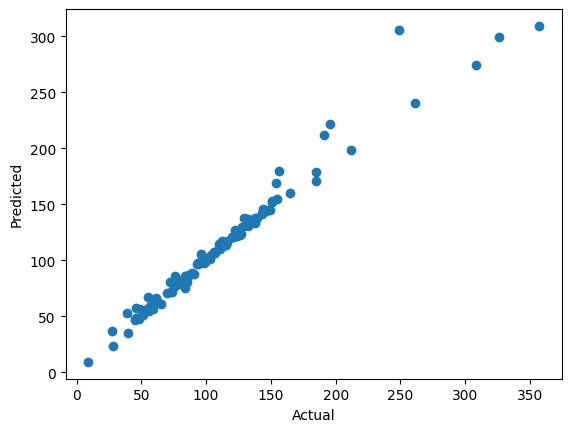

In [41]:
plt.scatter(y_test, y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

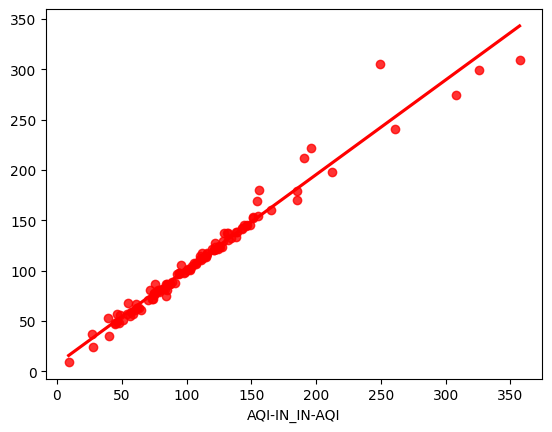

In [42]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

In [43]:
import pickle
with open("model.pkl", "wb") as f:
    mp = pickle.dump(rf_model, f)